In [1]:
import pandas as pd
from src.data import *
from src.portfolio import *
from src.efficient_frontier import *
from src.plot import *
import yfinance as yf
from scipy.optimize import Bounds, LinearConstraint
from pypfopt.expected_returns import mean_historical_return

In [2]:
esg_data = esg_score_weight(pd.read_excel('data/ESG_DATA.xlsx'), np.array([1/3,1/3,1/3]))
full_data = stock_monthly_close(esg_data, dates=('2003-01-01','2023-01-01'))
prices, esg = seperate_full_data(full_data)
prices = currency_rates(prices)


1 Failed download:
- JOBS.ST: No data found for this date range, symbol may be delisted

1 Failed download:
- PFE.ST: Exception('Lost data during merge despite all attempts to align data (see above)')

1 Failed download:
- GNP.OL: No data found, symbol may be delisted

1 Failed download:
- MSEIS.OL: No timezone found, symbol may be delisted

1 Failed download:
- JYSK.CO: Exception('Lost data during merge despite all attempts to align data (see above)')


In [3]:
prices = filter_prices(prices, 0, 10)
returns_pct_change = pct_returns_from_prices(prices)

In [4]:
parameters = []
for i in range(0, 11):
  #r_opt_set = set()
  print(f"-------------------------- 20{3+i:02d}-20{13+i:02d} --------------------------")

  # define the rolling window
  sample_rolling_window = returns_pct_change[i*12:i*12+(12*10)]

  ret_port = mean_return_annual(sample_rolling_window)

  cov_port = covariance_matrix_annual(sample_rolling_window)

  parameters.append(ef1(ret_port, cov_port))


-------------------------- 2003-2013 --------------------------
Min. Risk = 5.072% => Return: 10.647%  Sharpe Ratio = 2.10
Max. Sharpe Ratio = 4.23 => Return: 43.19%  Risk: 10.210%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2004-2014 --------------------------
Min. Risk = 4.740% => Return: 9.013%  Sharpe Ratio = 1.90
Max. Sharpe Ratio = 3.55 => Return: 31.40%  Risk: 8.837%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2005-2015 --------------------------
Min. Risk = 4.790% => Return: 10.817%  Sharpe Ratio = 2.26
Max. Sharpe Ratio = 3.20 => Return: 21.69%  Risk: 6.778%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2006-2016 --------------------------
Min. Risk = 5.051% => Return: 7.436%  Sharpe Ratio = 1.47
Max. Sharpe Ratio = 3.47 => Return: 41.34%  Risk: 11.921%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2007-2017 --------------------------
Min. Risk = 5.053% => Return: 2.630%  Sharpe Ratio = 0.52
Max. Sharpe Ratio = 3.17 => Return: 96.41%  Risk: 30.401%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2008-2018 --------------------------
Min. Risk = 4.992% => Return: 5.605%  Sharpe Ratio = 1.12
Max. Sharpe Ratio = 4.15 => Return: 76.20%  Risk: 18.353%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2009-2019 --------------------------
Min. Risk = 4.440% => Return: 6.217%  Sharpe Ratio = 1.40
Max. Sharpe Ratio = 5.66 => Return: 103.93%  Risk: 18.372%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2010-2020 --------------------------
Min. Risk = 4.177% => Return: 8.210%  Sharpe Ratio = 1.97
Max. Sharpe Ratio = 6.18 => Return: 81.33%  Risk: 13.170%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2011-2021 --------------------------
Min. Risk = 4.401% => Return: 8.834%  Sharpe Ratio = 2.01
Max. Sharpe Ratio = 5.24 => Return: 60.23%  Risk: 11.485%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2012-2022 --------------------------
Min. Risk = 4.428% => Return: 10.798%  Sharpe Ratio = 2.44
Max. Sharpe Ratio = 5.57 => Return: 56.62%  Risk: 10.173%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


-------------------------- 2013-2023 --------------------------
Min. Risk = 4.572% => Return: 8.435%  Sharpe Ratio = 1.85
Max. Sharpe Ratio = 4.24 => Return: 44.84%  Risk: 10.583%


/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:40: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,
/Users/nicolaiveiglinarends/Library/CloudStorage/OneDrive-UniversityofCopenhagen/DatØk3/Bachelorprojekt_repo/BachelorThesis/src/efficient_frontier.py:56: OptimizeWarning: Unknown solver options: xtol, gtol, barrier_tol
  result = minimize(function,


In [ ]:
expected_return = estimate_rolling_window(returns_pct_change).mean()

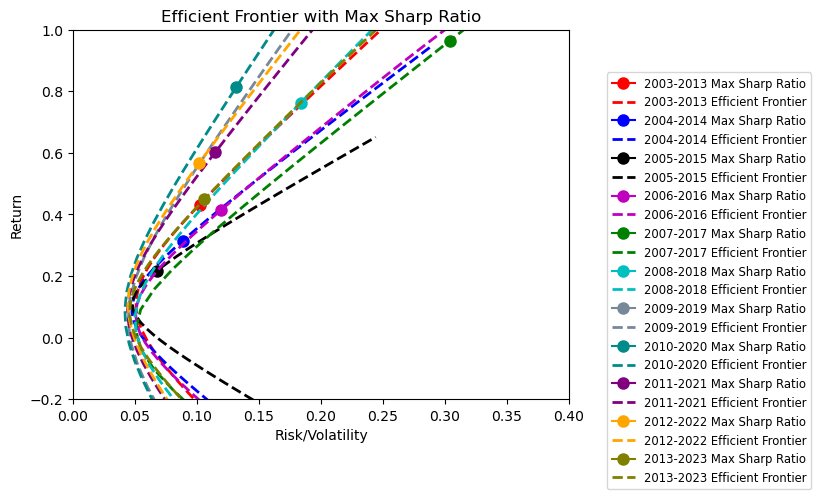

In [31]:
#mpl.style.use('classic')
mpl.style.use('default')

fig, ax = plt.subplots()
plt.title('Efficient Frontier with Max Sharp Ratio', fontsize=12)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
colors = ['r','b','k','m','g','c', 'lightslategrey', "darkcyan", "purple", "orange", "olive"]
for i, x in enumerate(parameters):
  opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, _ = x
  #ax.plot(opt_sr_vol, opt_sr_ret,'*', markersize=20, label=f'20{3+i:02d}-20{13+i:02d} Max Sharpe') # red star
  plt.plot(opt_sr_vol,  opt_sr_ret, marker='o', color = f'{colors[i]}', markersize=8, label=f'20{3+i:02d}-20{13+i:02d} Max Sharp Ratio') # red dot
  plt.plot(frontier_x, frontier_y, linestyle='--', color = f'{colors[i]}', linewidth=2, label=f'20{3+i:02d}-20{13+i:02d} Efficient Frontier') # red dashed line
  
  #ax.scatter(x[2], x[1], marker="*", s=100, label=f"20{3+i:02d}-20{13+i:02d} Max Sharpe")
plt.xlim([0.0,0.4])
plt.ylim([-0.2,1])
plt.legend(bbox_to_anchor =(0.5, 0.9, 1, 0), ncol = 1, fontsize="small")
#fig_path = os.path.join(PLOTS_PATH, f"efficient_frontier.png")
#plt.savefig(fig_path, dpi=150,bbox_inches="tight")
plt.show()

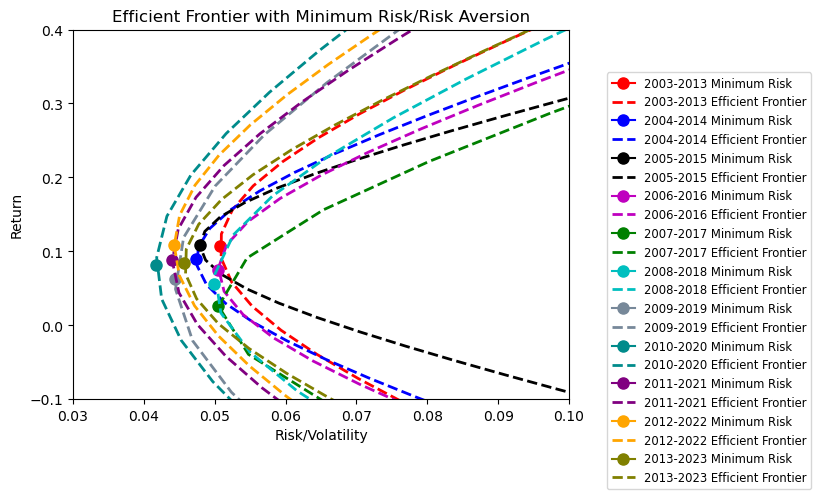

In [30]:
#mpl.style.use('classic')
mpl.style.use('default')

fig, ax = plt.subplots()
plt.title('Efficient Frontier with Minimum Risk/Risk Aversion', fontsize=12)
plt.xlabel('Risk/Volatility')
plt.ylabel('Return')
colors = ['r','b','k','m','g','c', 'lightslategrey', "darkcyan", "purple", "orange", "olive"]
for i, x in enumerate(parameters):
  opt_sr_vol, opt_sr_ret, opt_risk_vol,  opt_risk_ret, frontier_x, frontier_y, _ = x
  #ax.plot(opt_sr_vol, opt_sr_ret,'*', markersize=20, label=f'20{3+i:02d}-20{13+i:02d} Max Sharpe') # red star
  plt.plot(opt_risk_vol,  opt_risk_ret, marker='o', color = f'{colors[i]}', markersize=8, label=f'20{3+i:02d}-20{13+i:02d} Minimum Risk') # red dot
  plt.plot(frontier_x, frontier_y, linestyle='--', color = f'{colors[i]}', linewidth=2, label=f'20{3+i:02d}-20{13+i:02d} Efficient Frontier') # red dashed line
  
  #ax.scatter(x[2], x[1], marker="*", s=100, label=f"20{3+i:02d}-20{13+i:02d} Max Sharpe")
plt.xlim([0.03,0.1])
plt.ylim([-0.1,0.4])
plt.legend(bbox_to_anchor =(0.5, 0.9, 1, 0), ncol = 1, fontsize="small")
#fig_path = os.path.join(PLOTS_PATH, f"efficient_frontier.png")
#plt.savefig(fig_path, dpi=150,bbox_inches="tight")
plt.show()

In [ ]:
portfolio_mean(df)

In [ ]:
cov = portfolio_covariance(df)
portfolio_std(cov, w)

In [ ]:
portfolio_sharp_ratio(df, w, cov)

In [ ]:
#bounds = Bounds(-2, 5)

#Create x0, the first guess at the values of each asset's weight.
#w0 = np.linspace(start=1, stop=0, num=cov.shape[1])
#x0 = w0/np.sum(w0)
# All weights between 0 and 1
# # The second boundary is the sum of weights.
#linear_constraint = LinearConstraint(np.ones((cov.shape[1],), dtype=int),1,1)
#options = {'xtol': 1e-07, 'gtol': 1e-07, 'barrier_tol': 1e-07, 'maxiter': 1000}
 

In [ ]:
def portfolio_minimize_risk(port_return, 
                                port_covariance, 
                                esg_data, 
                                x0,
                                linear_constraint, 
                                bounds, 
                                options = None):
    """
    Function that will take different inputs including esg score data and compute the minimum risk of different portfolios 
    :param: A dataframe of the portfolio covariance matrix
    :param: A dataframe of esg scores of the different assets in portfolio
    :param: x0 argument that is the initial guess for the minimizer
    :param: Linear constraints for the minimizer
    :param: Bounds for the minimizer
    :param: 
    :param: Options for the minimizer
    :returns: A dataframe containing portfolio weight choice for minimizing portfolio risk using esg scores
    """
    
    results = {'esg':[],
               'weights':[],
               'risk':[],
               'return':[]}
    
    function = lambda weight: portfolio_std(port_cov=port_covariance, weights=weight)
    constraint_esg = {'type': 'eq', 'fun': lambda weight: np.dot(weight, esg_data)}
    result = minimize(function, 
                      x0, 
                      method='trust-constr', 
                      bounds=bounds, 
                      constraints=[linear_constraint, constraint_esg], 
                      options=options)
   
    optimal_weights = list(result['x'])
    print(optimal_weights)
    optimal_esg = np.dot(optimal_weights, esg_data)
    results['esg'].append(optimal_esg)
    results['weights'].append(optimal_weights)
    results['risk'].append(result['fun'])
    results['return'].append(np.dot(optimal_weights, port_return.sum()))

    return results


In [ ]:
# set the window size
#window_size = 2

# make different lists to append data in every window
#expected_return = []
#expected_year = []

#def simple_return(beginning_price, end_price):
#  return ((end_price-beginning_price)/beginning_price)

#def annual_return(simple_return, years_held):
#  return (((simple_return+1)**(1/years_held))-1)

# setup af loop to iterate through window and make calculations
#for i in range(0, 6):

  # define the rolling window
#  sample_rolling_window = df[i*12:i*12+(12*window_size)]

  # calculate the expected return as a dataframe
#  window_monthly_returns = pd.DataFrame()
#  window_monthly_returns = sample_rolling_window
#  simple_window_yearly_returns_mean = simple_return(window_monthly_returns.iloc[0], window_monthly_returns.iloc[-1])
#  annual_window_return = annual_return(simple_window_yearly_returns_mean, window_size)

  # append the results of expected return and the years to list
#  expected_return.append(annual_window_return)

# make list of expected return into a dataframe
#for x in range(2013, 2024):
#  expected_year.append(dt(x,1,1))
  
#expected_return = pd.DataFrame(expected_return, index=expected_year)

#expected_return


In [ ]:
#esg_data = pd.read_excel('ESG_DATA.XLS')
#for index, row in esg_data.iterrows():
    # stockholm exchange
    if row['Isin'].startswith('SE'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    
    # swiss exchange
    elif row['Isin'].startswith('CH0242214887'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('CH1122548808'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('CH'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SW'
    
    # toroto exchange
    elif row['Isin'].startswith('CA98936C1068'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    elif row['Isin'].startswith('CA'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.TO'
    elif row['Isin'].startswith('GB'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.L'
    
    # paris exchange
    elif row['Isin'].startswith('FR'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.PA'

    # copenhagen exchange
    
    elif row['Isin'].startswith('DK0060668796'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('DK0060520450'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FI4000297767'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO' 
    elif row['Isin'].startswith('DK'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.CO'

    # oslo exchange
    elif row['Isin'].startswith('NO'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('KYG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL' 
    elif row['Isin'].startswith('CY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('BMG'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('MHY'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
    elif row['Isin'].startswith('US36467X2062'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('SGX'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'
    elif row['Isin'].startswith('FO0000000179'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.OL'

    elif row['Isin'].startswith('MT0000580101'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.DE'
    elif row['Isin'].startswith('MT0001390104'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.ST'
    elif row['Isin'].startswith('MT'):
        esg_data.at[index, 'stock_symbol'] = row['stock_symbol'] + '.SG'
   